In [1]:
!pip install nltk bert-score
!pip install rouge-metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.2 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the saved CSV file
longformer_generated_summaries = pd.read_csv("longformer_generated_summaries.csv")

# Verify the data
print(longformer_generated_summaries.head(2))

          note_id                                              input  \
0  16002318-DS-17  <SEX> F <SERVICE> SURGERY <ALLERGIES> Iodine /...   
1   15638884-DS-4  <SEX> M <SERVICE> MEDICINE <ALLERGIES> Augment...   

                                              target  input_tokens  \
0  This is a ___ yo F admitted to the hospital af...          1195   
1  Mr. ___ is a ___ yo man with CAD with prior MI...          3496   

   target_tokens                       generated_summary_longformer  
0             75  > Past medical history includes sleep apnea, h...  
1           1143  You are a medical expert. Please summarize the...  


In [4]:
longformer_generated_summaries.nunique()

note_id                         100
input                           100
target                          100
input_tokens                    100
target_tokens                    91
generated_summary_longformer     83
dtype: int64

In [6]:
from tqdm import tqdm
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score
from rouge_metric import PyRouge

def clean_text(text):
    """Clean and normalize text."""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    return ' '.join(text.strip().lower().split())  # Lowercase, strip spaces, normalize.

def compute_bleu_scores(reference, candidate):
    """Compute BLEU-1 and BLEU-2 scores."""
    try:
        smoothing_function = SmoothingFunction().method1
        # Compute BLEU-1
        bleu1 = sentence_bleu(
            [reference.split()],
            candidate.split(),
            weights=(1.0, 0, 0, 0),  # Only unigrams
            smoothing_function=smoothing_function
        )
        # Compute BLEU-2
        bleu2 = sentence_bleu(
            [reference.split()],
            candidate.split(),
            weights=(0.5, 0.5, 0, 0),  # Unigrams and bigrams only
            smoothing_function=smoothing_function
        )
        return bleu1 * 100, bleu2 * 100  # Convert to percentages
    except Exception as e:
        print(f"BLEU Error: {e}")
        print(f"Reference: '{reference[:50]}...'")
        print(f"Candidate: '{candidate[:50]}...'")
        return 0.0, 0.0

def compute_rouge_l(reference, candidate):
    """Compute ROUGE-L score."""
    rouge = PyRouge(rouge_n=(1, 2), rouge_l=True, rouge_w=False,
                    rouge_w_weight=1.2, rouge_s=False, rouge_su=False, skip_gap=4)
    try:
        scores = rouge.evaluate([candidate], [[reference]])
        return scores['rouge-l']['f'] * 100  # Convert to percentage
    except Exception as e:
        print(f"ROUGE-L Error: {e}")
        print(f"Reference: '{reference[:50]}...'")
        print(f"Candidate: '{candidate[:50]}...'")
        return 0.0

def compute_bert_score_batched(references, candidates, batch_size=32):
    """Compute BERTScore in batches."""
    all_P, all_R, all_F1 = [], [], []
    for i in range(0, len(references), batch_size):
        batch_refs = references[i:i + batch_size]
        batch_cands = candidates[i:i + batch_size]
        try:
            P, R, F1 = score(batch_cands, batch_refs, lang="en", verbose=False)
            all_P.extend([p * 100 for p in P.tolist()])  # Convert to percentages
            all_R.extend([r * 100 for r in R.tolist()])  # Convert to percentages
            all_F1.extend([f * 100 for f in F1.tolist()])  # Convert to percentages
        except Exception as e:
            print(f"BERTScore Error in batch {i}: {e}")
            batch_len = len(batch_refs)
            all_P.extend([0.0] * batch_len)
            all_R.extend([0.0] * batch_len)
            all_F1.extend([0.0] * batch_len)
    return all_P, all_R, all_F1

def evaluate_summaries(df):
    bleu1_scores, bleu2_scores, rouge_l_scores = [], [], []
    print("Computing BLEU and ROUGE-L scores...")
    
    with tqdm(total=len(df), desc="Processing Rows", unit="row") as pbar:
        for _, row in df.iterrows():
            reference = clean_text(row['target'])
            candidate = clean_text(row['generated_summary_longformer'])  # Updated field name
            
            if not reference or not candidate:
                print(f"Empty text - Reference: '{reference}', Candidate: '{candidate}'")
                bleu1_scores.append(0.0)
                bleu2_scores.append(0.0)
                rouge_l_scores.append(0.0)
            else:
                bleu1, bleu2 = compute_bleu_scores(reference, candidate)
                bleu1_scores.append(bleu1)
                bleu2_scores.append(bleu2)
                rouge_l_scores.append(compute_rouge_l(reference, candidate))
            
            pbar.update(1)
    
    print("\nComputing BERTScore...")
    references = [clean_text(text) for text in df['target'].tolist()]
    candidates = [clean_text(text) for text in df['generated_summary_longformer'].tolist()]  # Updated field name
    bert_p, bert_r, bert_f1 = compute_bert_score_batched(references, candidates)
    
    # Add all scores to DataFrame
    df['bleu1'] = bleu1_scores
    df['bleu2'] = bleu2_scores
    df['rouge_l'] = rouge_l_scores
    df['bert_p'] = bert_p
    df['bert_r'] = bert_r
    df['bert_f1'] = bert_f1
    
    # Print evaluation metrics
    print("\nEvaluation Metrics (in percentages):")
    print("Average BLEU-1:", df['bleu1'].mean(), "%")
    print("Average BLEU-2:", df['bleu2'].mean(), "%")
    print("Average ROUGE-L:", df['rouge_l'].mean(), "%")
    print("Average BERT P:", df['bert_p'].mean(), "%")
    print("Average BERT R:", df['bert_r'].mean(), "%")
    print("Average BERT F1:", df['bert_f1'].mean(), "%")
    
    # Print standard deviations
    print("\nStandard Deviations (in percentages):")
    print("BLEU-1 Std:", df['bleu1'].std(), "%")
    print("BLEU-2 Std:", df['bleu2'].std(), "%")
    print("ROUGE-L Std:", df['rouge_l'].std(), "%")
    print("BERT F1 Std:", df['bert_f1'].std(), "%")
    
    return df

# Updated DataFrame Name
longformer_generated_summaries = evaluate_summaries(longformer_generated_summaries)
longformer_generated_summaries.to_csv("longformer_evaluation_results.csv", index=False)
print("\nResults saved to 'longformer_evaluation_results.csv'")


Computing BLEU and ROUGE-L scores...


Processing Rows: 100%|██████████| 100/100 [00:02<00:00, 40.99row/s]


Computing BERTScore...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro


Evaluation Metrics (in percentages):
Average BLEU-1: 2.7563261803395442 %
Average BLEU-2: 0.7456357857259732 %
Average ROUGE-L: 3.0961225536193564 %
Average BERT P: 72.48901945352554 %
Average BERT R: 77.16412711143494 %
Average BERT F1: 74.70228332281113 %

Standard Deviations (in percentages):
BLEU-1 Std: 4.714905684629328 %
BLEU-2 Std: 1.6666475676102706 %
ROUGE-L Std: 2.9026986514516517 %
BERT F1 Std: 3.070743688598214 %

Results saved to 'longformer_evaluation_results.csv'


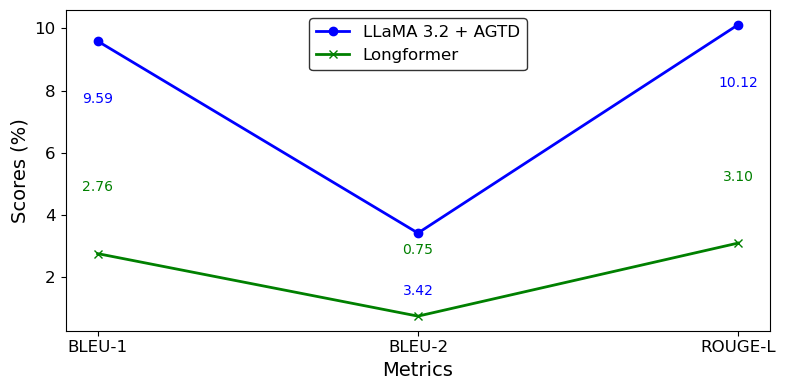

In [28]:
import matplotlib.pyplot as plt

# Data for the chart
metrics = ['BLEU-1', 'BLEU-2', 'ROUGE-L']
llama_agtd_scores = [9.59, 3.42, 10.12]  # Scores for LLaMA 3.2 + AGTD
longformer_scores = [2.76, 0.75, 3.10]  # Scores for Longformer

# X-axis positions for the metrics
x = range(len(metrics))

# Create the plot
plt.figure(figsize=(8, 4))

# Plot scores for LLaMA 3.2 + AGTD
plt.plot(x, llama_agtd_scores, marker='o', label='LLaMA 3.2 + AGTD', color='blue', linewidth=2)
plt.plot(x, longformer_scores, marker='x', label='Longformer', color='green', linewidth=2)

# Adding labels close to the lines
for i, score in enumerate(llama_agtd_scores):
    plt.text(i, score - 2, f'{score:.2f}', ha='center', fontsize=10, color='blue')  # Adjust placement above/below
for i, score in enumerate(longformer_scores):
    plt.text(i, score + 2, f'{score:.2f}', ha='center', fontsize=10, color='green')  # Adjust placement above/below

# Add axis labels
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores (%)', fontsize=14)

# Add a legend
plt.legend(loc='best', fontsize=12, frameon=True, shadow=False, fancybox=True, edgecolor='black')

# No grid, clean white background
plt.grid(False)

# Adjust layout for clean spacing
plt.tight_layout()

# Save the plot as a PDF (Overleaf-friendly format)
plt.savefig('line_chart_metrics_comparison.pdf', format='pdf')

# Show the plot (for preview)
plt.show()
